In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn



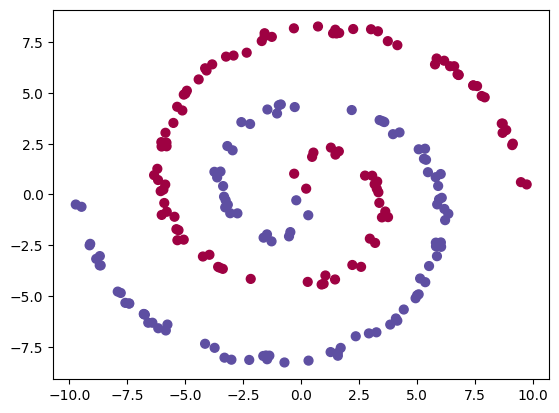

In [23]:


def create_spiral_data(points, noise=1.0):
    n = np.sqrt(np.random.rand(points//2,1)) * 540 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(points//2,1) * noise
    d1y = np.sin(n)*n + np.random.rand(points//2,1) * noise
    X = np.vstack((np.hstack((d1x,d1y)), np.hstack((-d1x,-d1y))))
    Y = np.hstack((np.zeros(points//2),np.ones(points//2)))
    return X, Y

X, Y = create_spiral_data(200, noise=0.5)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [24]:
X1= torch.from_numpy(X).type(torch.float)
y1= torch.from_numpy(Y).type(torch.float)
X1.dtype,y1.dtype

(torch.float32, torch.float32)

In [25]:
X1.shape

torch.Size([200, 2])

In [26]:
y1.shape

torch.Size([200])

In [27]:
print(f"x1:{X1[:5]}")

x1:tensor([[ 1.4757,  1.9630],
        [ 7.4204,  5.3684],
        [-6.0591,  0.1642],
        [ 3.0606,  0.9233],
        [ 3.7429, -1.1150]])


In [28]:
print(f"y1:{y1[:5]}")

y1:tensor([0., 0., 0., 0., 0.])


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train,X_test,Y_train,Y_test =train_test_split(X1,y1,test_size=0.2,random_state=42)
len(X_train),len(X_test),len(Y_train),len(Y_test)

(160, 40, 160, 40)

In [31]:
class SpiralModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer1= nn.Linear(in_features=2,out_features=8)
    self.linear_layer2=nn.Linear(in_features=8,out_features=8)
    self.linear_layer3=nn.Linear(in_features=8,out_features=1)
    self.relu=nn.ReLU()
  def forward(self,x):
    return self.linear_layer3(self.linear_layer2(self.relu(self.linear_layer1(x))))
model_0 = SpiralModelV1()
model_0

SpiralModelV1(
  (linear_layer1): Linear(in_features=2, out_features=8, bias=True)
  (linear_layer2): Linear(in_features=8, out_features=8, bias=True)
  (linear_layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [32]:
with torch.inference_mode():
  demologits=model_0(X_test)
print(f"Logits:{demologits[:5]}")
demo_prob = torch.sigmoid(demologits)
print(f"prob:{demo_prob[:5]}")
prob_label= torch.round(demo_prob)
print(f"prob_labels:{prob_label[:5]}")



Logits:tensor([[-2.2637],
        [ 0.0720],
        [ 0.1509],
        [ 0.1243],
        [-0.1817]])
prob:tensor([[0.0942],
        [0.5180],
        [0.5376],
        [0.5310],
        [0.4547]])
prob_labels:tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [34]:
def accuracy_fn(Y_true,Y_pred):
  correct = torch.eq(Y_true,Y_pred).sum().item()
  acc= correct/len(Y_pred)
  return acc

In [68]:
torch.manual_seed(42)

epochs=1000
for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  accuracy= accuracy_fn(Y_true=Y_train,Y_pred=y_pred)
  loss= loss_fn(y_logits,Y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    t_logits= model_0(X_test).squeeze()
  t_pred=torch.round(torch.sigmoid(t_logits))
  t_accuracy= accuracy_fn(Y_true=Y_test,Y_pred=t_pred)
  t_loss=loss_fn(t_logits,Y_test)
  if epoch %100==0:
    print(f"epochs:{epoch} |  train accuracy :{accuracy:.2f}% | train_loss:{loss:.5f} |  test_accuracy :{t_accuracy:.2f}%  |  test_loss: {t_loss:.5f}")





epochs:0 |  train accuracy :0.99% | train_loss:0.02253 |  test_accuracy :0.97%  |  test_loss: 0.02378
epochs:100 |  train accuracy :0.99% | train_loss:0.02253 |  test_accuracy :0.97%  |  test_loss: 0.02399
epochs:200 |  train accuracy :0.99% | train_loss:0.02257 |  test_accuracy :0.97%  |  test_loss: 0.02449
epochs:300 |  train accuracy :0.99% | train_loss:0.02261 |  test_accuracy :0.97%  |  test_loss: 0.02475
epochs:400 |  train accuracy :0.99% | train_loss:0.02261 |  test_accuracy :0.97%  |  test_loss: 0.02477
epochs:500 |  train accuracy :0.99% | train_loss:0.02262 |  test_accuracy :0.97%  |  test_loss: 0.02482
epochs:600 |  train accuracy :0.99% | train_loss:0.02262 |  test_accuracy :0.97%  |  test_loss: 0.02487
epochs:700 |  train accuracy :0.99% | train_loss:0.02263 |  test_accuracy :0.97%  |  test_loss: 0.02492
epochs:800 |  train accuracy :0.99% | train_loss:0.02264 |  test_accuracy :0.97%  |  test_loss: 0.02496
epochs:900 |  train accuracy :0.99% | train_loss:0.02264 |  test_a

In [39]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

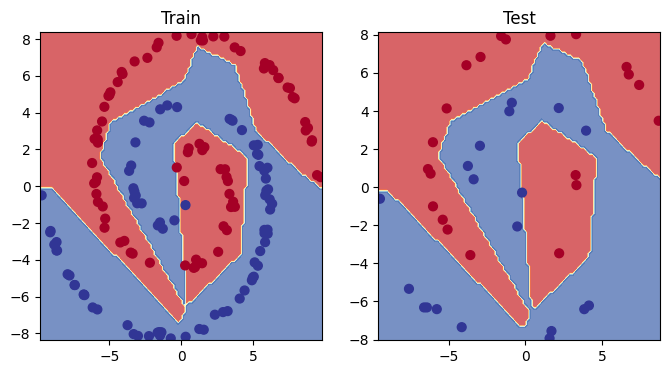

In [69]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,Y_test)